In [17]:
# make sure, the numpy library only uses one thread
import os
os.environ["OMP_NUM_THREADS"]="1"

# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate

# import models
from earm.lopez_direct import model as md
from earm.lopez_indirect import model as mi
from earm.lopez_embedded import model as me
from pysb.simulator import ScipyOdeSimulator

In [18]:
# load experimental data
exp_data = pd.read_csv('EC-RP_IMS-RP_IC-RP_data_for_models.csv', index_col=False)

# read time points from data file
tspan = exp_data['# Time'].values.copy()

# use the rate parameters that are hardcoded into the model
param_values_i = np.array([p.value for p in mi.parameters])
param_values_d = np.array([p.value for p in md.parameters])
param_values_e = np.array([p.value for p in me.parameters])


# arguments for the model simulation (solve the ODEs)
args = {'integrator': 'lsoda', 'use_analytic_jacobian': True}

# simulate the models
solver_i = ScipyOdeSimulator(mi, tspan, **args)
solver_d = ScipyOdeSimulator(md, tspan, **args)
solver_e = ScipyOdeSimulator(me, tspan, **args)

In [19]:
# save the trajectories of the ODE integration for analysis
traj_i = solver_i.run(param_values=param_values_i)
traj_d = solver_d.run(param_values=param_values_d)
traj_e = solver_e.run(param_values=param_values_e)


# normalize the trajectories to the initial conditions
normal_bid_factor = mi.parameters['Bid_0'].value
normal_smac_factor = mi.parameters['Smac_0'].value
normal_parp_factor = mi.parameters['PARP_0'].value

bid_traj_i = traj_i.observables['mBid'] / normal_bid_factor
bid_traj_d = traj_d.observables['mBid'] / normal_bid_factor
bid_traj_e = traj_e.observables['mBid'] / normal_bid_factor

aSmac_traj_i = traj_i.observables['aSmac'] / normal_smac_factor
aSmac_traj_d = traj_d.observables['aSmac'] / normal_smac_factor
aSmac_traj_e = traj_e.observables['aSmac'] / normal_smac_factor

cparp_traj_i = traj_i.observables['cPARP'] / normal_parp_factor
cparp_traj_d = traj_d.observables['cPARP'] / normal_parp_factor
cparp_traj_e = traj_e.observables['cPARP'] / normal_parp_factor

In [20]:
print(exp_data)

     # Time   IC-RP  norm_IC-RP  nrm_var_IC-RP  IMS-RP  IMS-RP step  VAR  \
0       180  0.7063         0.0         0.0006     0.0          0.0  1.0   
1       360  0.7063         0.0         0.0006     0.0          0.0  1.0   
2       540  0.7063         0.0         0.0006     0.0          0.0  1.0   
3       720  0.7063         0.0         0.0006     0.0          0.0  1.0   
4       900  0.7063         0.0         0.0006     0.0          0.0  1.0   
..      ...     ...         ...            ...     ...          ...  ...   
107   19440  1.2533         1.0         0.0063     1.0          1.0  1.0   
108   19620  1.2579         1.0         0.0063     1.0          1.0  1.0   
109   19800  1.2531         1.0         0.0063     1.0          1.0  1.0   
110   19980  1.2571         1.0         0.0063     1.0          1.0  1.0   
111   20160  1.2580         1.0         0.0063     1.0          1.0  1.0   

      EC-RP  norm_EC-RP  nrm_var_EC-RP  
0    0.4451      0.0020         0.0003  
1    

In [21]:
print(len(traj_i.observables['mBid']),len(exp_data['norm_IC-RP']))

112 112


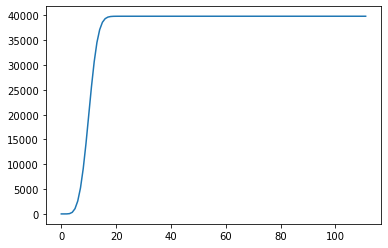

In [22]:
plt.plot(traj_i.observables['mBid'], )

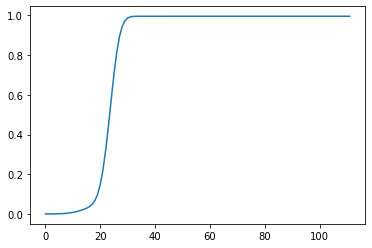

In [23]:
plt.plot(traj_e.observables['mBid'] / me.parameters['Bid_0'].value)

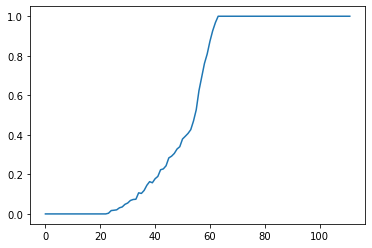

In [24]:
plt.plot(exp_data['norm_IC-RP'])

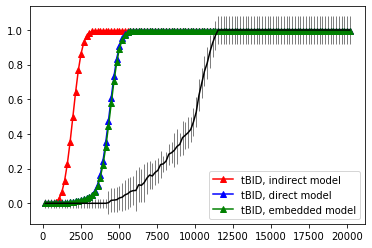

In [25]:
# plot and compare tBid

plt.plot(tspan, bid_traj_i, color='r', marker='^', label='tBID, indirect model')
plt.plot(tspan, bid_traj_d, color='b', marker='^', label='tBID, direct model')
plt.plot(tspan, bid_traj_e, color='g', marker='^', label='tBID, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_IC-RP'],yerr=exp_data['nrm_var_IC-RP'] ** .5,
             ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

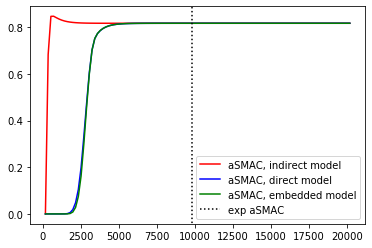

In [26]:
# plot and compare Smac
# the release of Smac is in a Snap action ([Albeck2008])
# this data displays the time in which this snap happens

# Mean and variance of Td (delay time) and Ts (switching time) of MOMP, and
# yfinal (the last value of the IMS-RP trajectory)
momp_data = np.array([9810.0, 180.0, mi.parameters['Smac_0'].value])
momp_var = np.array([7245000.0, 3600.0, 1e4])

plt.plot(tspan, aSmac_traj_i, color='r', label='aSMAC, indirect model')
plt.plot(tspan, aSmac_traj_d, color='b', label='aSMAC, direct model')
plt.plot(tspan, aSmac_traj_e, color='g', label='aSMAC, embedded model')
plt.axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',label='exp aSMAC')
plt.legend(loc=0)

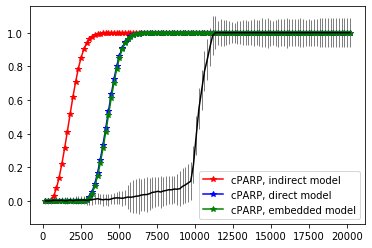

In [27]:
# plot and compare PARP

plt.plot(tspan, cparp_traj_i, color='r', marker='*', label='cPARP, indirect model')
plt.plot(tspan, cparp_traj_d, color='b', marker='*', label='cPARP, direct model')
plt.plot(tspan, cparp_traj_e, color='g', marker='*', label='cPARP, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_EC-RP'],
                 yerr=exp_data['nrm_var_EC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

In [28]:
# define a function which evaluates how far the model is away from the real data
# this cost function is based on the chi^2 test
# this cost function is specifically tailored to EARM

def likelihood(position):
    param_values[rate_mask] = 10 ** position
    traj = solver.run(param_values=param_values)

    model = mi
    # normalize trajectories
    bid_traj = traj.observables['mBid'] / model.parameters['Bid_0'].value
    cparp_traj = traj.observables['cPARP'] / model.parameters['PARP_0'].value
    momp_traj = traj.observables['aSmac']

    # calculate chi^2 distance for each time course
    e1 = np.sum((exp_data['norm_IC-RP'] - bid_traj) ** 2 /
                (2 * exp_data['nrm_var_IC-RP'])) / len(bid_traj)

    e2 = np.sum((exp_data['norm_EC-RP'] - cparp_traj) ** 2 /
                (2 * exp_data['nrm_var_EC-RP'])) / len(cparp_traj)

    # Here we fit a spline to find where we get 50% release of MOMP reporter
    if np.nanmax(momp_traj) == 0:
        print('No aSmac!')
        t10 = 0
        t90 = 0
    else:
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        try:
            t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
            t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        except IndexError:
            t10 = 0
            t90 = 0

    # time of death  = halfway point between 10 and 90%
    td = (t10 + t90) / 2

    # time of switch is time between 90 and 10 %
    ts = t90 - t10

    # final fraction of aSMAC (last value)
    yfinal = momp_traj[-1]
    momp_sim = [td, ts, yfinal]

    e3 = np.sum((momp_data - momp_sim) ** 2 / (2 * momp_var)) / 3
    # return sum of errors ( the ',' is required)
    return e1 + e2 + e3,

In [29]:
# load simple PSO for the particle swarm optimization
# this method re-evaluates the rate constants
# and tailors them to the real data
from simplepso.pso import PSO

# get the original parameters from the model
rate_params_i = mi.parameters_rules()
rate_params_d = md.parameters_rules()
rate_params_e = me.parameters_rules()

# the parameter set also includes initial conditions 
# those are not to be changed, so this mask filters
# purely the rates from the parameters which need to be trained
rate_mask_i = np.array([p in rate_params_i for p in mi.parameters])
rate_mask_d = np.array([p in rate_params_d for p in md.parameters])
rate_mask_e = np.array([p in rate_params_e for p in me.parameters])

# the original values are used as starting position for the PSO
# PSO searches in log-space for efficiency, therefore, the
# initial data is transformed into log-space
starting_position_i = np.log10(param_values_i[rate_mask_i])
starting_position_d = np.log10(param_values_d[rate_mask_d])
starting_position_e = np.log10(param_values_e[rate_mask_e])

# create a PSO object for the first model
# the parameter values to be trained are the rates from this model
param_values = param_values_i
rate_mask = rate_mask_i
solver = solver_i
pso_i = PSO(save_sampled=False, verbose=True, num_proc=4)
# use the above defined likelihood function as cost-function for the PSO
pso_i.set_cost_function(likelihood)
pso_i.set_start_position(starting_position_i)
pso_i.set_bounds(2)

# run to minimize for the best fit 
# if stopping criteria is reached, run again
pso_i.run(num_particles=25, num_iterations=50, stop_threshold=1e-5)

iteration	best   	avg             	std             	min         	max              
1        	22.7705	[28625.42323541]	[42604.34639601]	[22.7704924]	[126690.99098151]
2        	15.8943	[62409.28506584]	[67090.65327801]	[15.89431009]	[172709.60512045]
3        	15.8943	[62409.28506584]	[67090.65327801]	[15.89431009]	[172709.60512045]
4        	15.8943	[62409.28449924]	[67090.65346618]	[15.89431009]	[172709.60512045]
5        	15.8943	[62412.94185163]	[67091.5378781] 	[15.89431009]	[172709.60512045]
6        	15.8943	[62415.96496307]	[67096.27359702]	[15.89431009]	[172709.60512045]
7        	15.8943	[62416.68630779]	[67097.40402386]	[15.89431009]	[172709.60512045]
8        	15.8943	[62416.04321358]	[67096.42586474]	[15.89431009]	[172709.60512045]
9        	15.8943	[62414.17629494]	[67093.52721744]	[15.89431009]	[172709.60512045]
10       	15.8943	[62416.33466004]	[67096.964697]  	[15.89431009]	[172709.60516619]
11       	15.8943	[62416.83642802]	[67097.64891581]	[15.89431009]	[172709.6213

In [30]:
# new rate parameters for the indirect model
display(pso_i.best)

# run indirect model with newly suggested rates
# results of PSO are in log-space -> retransform into normal space
param_values[rate_mask] = 10 ** pso_i.best

# save the new parameters for later use in an external csv file
np.savetxt("fitted_model_i_parameters.csv", param_values)

# run the indirect model with the new rate parameters
traj_i = solver_i.run(param_values=param_values)

# normalize the results again
bid_traj_i = traj_i.observables['mBid'] / normal_bid_factor
cparp_traj_i = traj_i.observables['cPARP'] / normal_parp_factor
aSmac_traj_i = traj_i.observables['aSmac'] / normal_smac_factor

Particle([-8.39794001, -5.        , -7.        , -5.02322779, -2.37659015,
          -2.        , -7.57638605, -5.        ,  1.67865788, -4.25745881,
          -1.        , -8.        , -1.04919949,  0.        , -3.19785535,
          -3.99894218, -3.79756568, -8.30103   , -4.20051689, -2.        ,
          -5.30103   , -1.        , -7.85721975, -1.02049757, -2.        ,
          -3.69897   , -5.        , -3.15490196, -5.        , -5.00104448,
          -5.        , -2.        , -7.67042106, -4.93067055, -2.92546834,
          -6.39937232, -2.95627589, -2.        , -7.98127585, -1.00008066,
           1.9961558 , -5.52332949, -5.        ,  0.10186133,  0.9971185 ,
          -3.32921451,  0.        , -4.        , -0.2002576 ,  0.        ,
           0.        ,  0.        , -3.97205504, -3.92390284, -8.        ,
          -3.18045606, -8.        ,  0.0426986 , -4.02964231, -0.64794096,
          -4.        , -4.        , -7.97605581,  0.        , -7.87304453,
           0.69897   , -4

In [33]:
# do PSO for the direct model

param_values = param_values_d
rate_mask = rate_mask_d
solver = solver_d
pso_d = PSO(save_sampled=False, verbose=True, num_proc=4)
pso_d.set_cost_function(likelihood)
pso_d.set_start_position(starting_position_d)
pso_d.set_bounds(2)

pso_d.run(num_particles=25, num_iterations=50, stop_threshold=1e-5)

iteration	best   	avg             	std             	min           	max              
1        	117.261	[56795.28717631]	[66131.33454278]	[117.26089305]	[167471.29560511]
No aSmac!
No aSmac!
2        	30.0504	[97766.96034217]	[77377.50656857]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
3        	30.0504	[97766.96034217]	[77377.50656857]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
4        	30.0504	[97767.09136446]	[77377.6241089] 	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
5        	30.0504	[97767.67766051]	[77371.48016572]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
6        	30.0504	[97770.48589105]	[77374.02891506]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
7        	30.0504	[97763.73368863]	[77385.49813395]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
8        	30.0504	[97755.09001687]	[77394.02263657]	[30.05043361] 	[168992.35220993]
No aSmac!
No aSmac!
9        	30.0504	[97755.87577281]	[77390.95488211]	[30.05043361] 	[168992.

In [34]:
#run direct model with newly suggested rates
param_values[rate_mask] = 10 ** pso_d.best
np.savetxt("fitted_model_d_parameters.csv", param_values)
traj_d = solver_d.run(param_values=param_values)

bid_traj_d = traj_d.observables['mBid'] / normal_bid_factor
cparp_traj_d = traj_d.observables['cPARP'] / normal_parp_factor
aSmac_traj_d = traj_d.observables['aSmac'] / normal_smac_factor

In [36]:
# do PSO for the embedded model

param_values = param_values_e
rate_mask = rate_mask_e
solver = solver_e
pso_e = PSO(save_sampled=False, verbose=True, num_proc=4)
pso_e.set_cost_function(likelihood)
pso_e.set_start_position(starting_position_e)
pso_e.set_bounds(2)

pso_e.run(num_particles=25, num_iterations=50, stop_threshold=1e-5)

iteration	best   	avg             	std             	min          	max              
1        	12.8508	[62819.16207549]	[68709.59349988]	[12.85081697]	[167575.88124881]
No aSmac!
2        	12.8508	[85449.42370981]	[79713.22344886]	[80.85442266]	[178319.94455095]
No aSmac!
3        	12.8508	[85449.97809046]	[79712.91830923]	[80.85442266]	[178319.94455095]
No aSmac!
4        	12.8508	[85450.32917524]	[79712.71067421]	[80.85442266]	[178319.94455095]
No aSmac!
5        	12.8508	[85450.33460907]	[79712.70485478]	[80.99026839]	[178319.94455095]
No aSmac!
6        	12.8508	[inf]           	[nan]           	[81.6237457] 	[inf]            
No aSmac!
7        	12.8508	[85448.47449206]	[79713.71656996]	[81.6237457] 	[178319.94455095]
No aSmac!
8        	12.8508	[85450.35203158]	[79712.6957405] 	[81.6237457] 	[178319.94455095]
No aSmac!
9        	12.8508	[85450.36030255]	[79712.67807956]	[81.6237457] 	[178319.94455095]
No aSmac!
10       	12.8508	[85450.92209739]	[79712.00577588]	[81.61414209]	[178

In [37]:
# run embedded model with newly suggested rates
param_values[rate_mask] = 10 ** pso_e.best
np.savetxt("fitted_model_e_parameters.csv", param_values)
traj_e = solver_e.run(param_values=param_values)

bid_traj_e = traj_e.observables['mBid'] / normal_bid_factor
cparp_traj_e = traj_e.observables['cPARP'] / normal_parp_factor
aSmac_traj_e = traj_e.observables['aSmac'] / normal_smac_factor

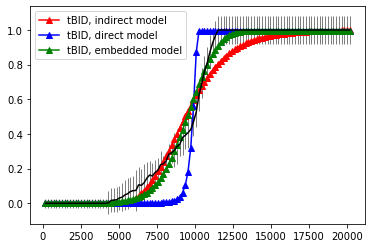

In [38]:
# compare the models using the new rates with the experimental data

plt.plot(tspan, bid_traj_i, color='r', marker='^', label='tBID, indirect model')
plt.plot(tspan, bid_traj_d, color='b', marker='^', label='tBID, direct model')
plt.plot(tspan, bid_traj_e, color='g', marker='^', label='tBID, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_IC-RP'],
                 yerr=exp_data['nrm_var_IC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)

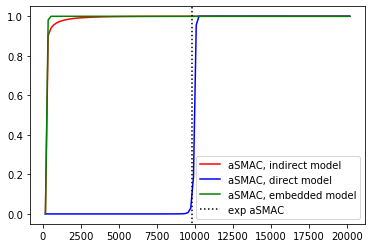

In [39]:
plt.plot(tspan, aSmac_traj_i, color='r', label='aSMAC, indirect model')
plt.plot(tspan, aSmac_traj_d, color='b', label='aSMAC, direct model')
plt.plot(tspan, aSmac_traj_e, color='g', label='aSMAC, embedded model')
plt.axvline(momp_data[0], -0.05, 1.05, color='black', linestyle=':',
               label='exp aSMAC')
plt.legend(loc=0)

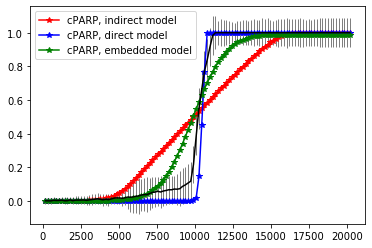

In [40]:
plt.plot(tspan, cparp_traj_i, color='r', marker='*', label='cPARP, indirect model')
plt.plot(tspan, cparp_traj_d, color='b', marker='*', label='cPARP, direct model')
plt.plot(tspan, cparp_traj_e, color='g', marker='*', label='cPARP, embedded model')
plt.errorbar(exp_data['# Time'], exp_data['norm_EC-RP'],
                 yerr=exp_data['nrm_var_EC-RP'] ** .5,
                 ecolor='black', color='black', elinewidth=0.5, capsize=0)
plt.legend(loc=0)